# 8. Predicting Personality Index (Frame selection)

In [1]:
from src import *

In [2]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

from sklearn.metrics import make_scorer
from sklearn.metrics import make_scorer

In [3]:
# To deal with convergence warnings in sklearn, I know that some weighting search wont allow convergence !!!!!
import sys
import warnings
warnings.filterwarnings("ignore")

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [4]:
from statannotations.Annotator import Annotator

In [5]:
# Used for scoring argument in fold scoring
def pearson_corrscore(y_true, y_pred):
    ret = pearson_correlation(y_true, y_pred)
    return ret

scoring_method = make_scorer(pearson_corrscore, greater_is_better=True)

D = lambda x,y: ((x-y)**2).sum(axis=1)

# we use default hyperparameters
def compute_outer_fold(X, y, n_iter, searchspace, score_scheme, inner_splits=4, outer_splits=3, verbose=False,
                      seed=0):
    """
    Nested cross validation using Lasso
    """
    # https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
    list_scores = []
    
    for k in tqdm(range(n_iter), disable=not verbose):
        rs = seed+k
        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=inner_splits, shuffle=True, random_state=rs)
        # define the model
        model = Lasso()
        # define search space
        space = dict()
        space['alpha'] = lambda_grid
        # define search
        search = GridSearchCV(model, space, scoring=score_scheme, n_jobs=-1, cv=cv_inner, refit=True)
        # configure the cross-validation procedure
        cv_outer = KFold(n_splits=outer_splits, shuffle=True, random_state=rs)
        # execute the nested cross-validation
        scores = cross_val_score(search, X, y, scoring=scoring_method, cv=cv_outer, n_jobs=-1)
        # report performance
        list_scores.append(scores)
        
    return list_scores

def compute_outer_fold_and_weights(X, y, n_iter, searchspace, score_scheme, inner_splits=4, 
                                   outer_splits=3, verbose=False, seed=0):
    """
    Nested cross validation using Lasso
    """
    # https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
    list_scores = []
    list_weights = []
    
    for k in tqdm(range(n_iter), disable=not verbose):
        
        rs = seed+k
        outer_results = list()
        weight_results = []
        cv_outer = KFold(n_splits=outer_splits, shuffle=True, random_state=rs)        
        for train_ix, test_ix in cv_outer.split(X):

            # split data
            X_train, X_test = X[train_ix, :], X[test_ix, :]
            y_train, y_test = y[train_ix], y[test_ix]
            # configure the cross-validation procedure
            cv_inner = KFold(n_splits=inner_splits, shuffle=True, random_state=rs)
            # define the model
            model = Lasso()
            # define search space
            space = dict()
            space['alpha'] = lambda_grid
            # define search
            search = GridSearchCV(model, space, scoring=score_scheme, n_jobs=-1, cv=cv_inner, refit=True)
            # execute search
            result = search.fit(X_train, y_train)
            # get the best performing model fit on the whole training set
            best_model = result.best_estimator_
            # evaluate model on the hold out dataset
            yhat = best_model.predict(X_test)
            # evaluate the model
            acc = pearson_corrscore(y_test, yhat)
            # store the result
            outer_results.append(acc)
            weight_results.append(result.best_estimator_)
            
        list_scores.append(outer_results)
        list_weights.append(weight_results)
        
    return list_scores, list_weights

In [6]:
def format_results2df(B, preds, base, preds_null, base_null, psy_array):
    """
    Move the results of nested cross to dataframe arrangement for plotting
    """
    pred_df = {"type": [], "pidx": [], "corr": []}
    for _type in B:
        for feat in psy_array:
            fold_pred = np.asarray(preds[_type][feat]).mean(axis=1)

            pred_df['type'] += [_type] * len(fold_pred)
            pred_df['pidx'] += [feat] * len(fold_pred)
            pred_df['corr'] += list(fold_pred)

    # add rest and movie as a baseline
    for _type in ['movie','rest']:
        for feat in psy_array:
            fold_pred = np.asarray(base[_type][feat]).mean(axis=1)

            pred_df['type'] += [_type] * len(fold_pred)
            pred_df['pidx'] += [feat] * len(fold_pred)
            pred_df['corr'] += list(fold_pred)

    pred_df = pd.DataFrame.from_dict(pred_df)

    null_df = {"type": [], "pidx": [], "corr": []}
    for _type in B:
        for feat in psy_array:
            fold_pred = np.asarray(preds_null[_type][feat]).mean(axis=1)

            null_df['type'] += [_type] * len(fold_pred)
            null_df['pidx'] += [feat] * len(fold_pred)
            null_df['corr'] += list(fold_pred)

    # add rest and movie as a baseline
    for _type in ['movie','rest']:
        for feat in psy_array:
            fold_pred = np.asarray(base_null[_type][feat]).mean(axis=1)

            null_df['type'] += [_type] * len(fold_pred)
            null_df['pidx'] += [feat] * len(fold_pred)
            null_df['corr'] += list(fold_pred)

    null_df = pd.DataFrame.from_dict(null_df)
    
    return pred_df, null_df


def fold_weightings_lasso(fold_lassos):
    """ 
    Take as argument
    """
    tmp = np.asarray(fold_lassos).flatten()
    weights = np.asarray([t.coef_ for t in tmp])
    return weights

def percentile2coord(tup, S):
    """ 
    Quick transpose of percentile values to coordinates in matrix
    """
    a = S.index((tup[0],tup[1]))
    b = S.index((tup[2],tup[3]))
    return a,b

## Description

We predict personality index from gradients

GOAL: Predicting personality index from gradients

## Table of Contents

- [On full movie Static Gradients](#staticgrad)
- [On frame selected Static Gradients focused on specific pidx](#fselect-staticgrad-focus)
- [On frame selected Static Gradients](#fselect-staticgrad)



#### Loading behavioural scores

In [153]:
behavioural  = pd.read_excel('./data/labels/Behavioural_PSY_scored.xlsx')
existing_psy = list(behavioural.columns[-15:])

psy1 = existing_psy[:len(existing_psy)//2]
psy2 = existing_psy[len(existing_psy)//2:]
# verbose1 = ['covid stress', 'DASS depression','DASS anxiety', 'DASS stress', 'BAS drive', 
#             'BAS funseeking', 'BAS reward responsiveness']
# verbose2 = ['BIS', 'BIG5 extraversion', 'BIG5 agreeableness', 'BIG5 conscientiousness', 
#             'BIG5 neuroticism', 'BIG5 openness', 'ERQ reappraisal', 'ERQ supression']

verbose1 = ['Pandemic stress', 'State Depression','State Anxiety', 'State Stress', 'Drive', 
            'Fun-seeking', 'Reward responsiveness']
verbose2 = ['Behavioural Inhibition', 'Extraversion', 'Agreeableness', 'Conscientiousness', 
            'Neuroticism', 'Openness', 'Cognitive Reappraisal', 'Expressive Suppression']

regions = list(index2region.keys())

In [8]:
s5 = [(s,s+5) for s in range(0,101,5) if (s+5 <= 100)]
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]

<a class="anchor" id="staticgrad"></a>
## On full movie Static Gradients

In [9]:
supermovie_grads = load('./resources/static_grad/individual_level/SUPERMOVIE_grad414.pkl')
rest_grads = load('./resources/static_grad/individual_level/Rest_grad414.pkl')

subjects = list(rest_grads.keys())
nsub = len(subjects)

supermovie_dist = {}
rest_dist = {}
for _id in subjects:
    # 1. Movie
    tmp_grads = supermovie_grads[_id]
    dist = D(tmp_grads.mean(axis=0), tmp_grads)
    supermovie_dist[_id] = dist
    
    # 2. Rest
    tmp_grads = rest_grads[_id]
    dist = D(tmp_grads.mean(axis=0), tmp_grads)
    rest_dist[_id] = dist

#### Regress / Predictive Example for hyperparameter space search

In [11]:
n_iter = 100
# empirically / arbitrarily picked space search
lambda_grid = [10**(i) for i in range(-3,4)] + [5] + [20] + [30] + [50]

np.random.seed(99)
grads_dist = [supermovie_dist, rest_dist]
psyscore = [behavioural[behavioural.ID == subjects[i]]['DASS_anx'].item() for i in range(len(subjects))]
psyscore = zscore(np.array(psyscore))

Xmovie = np.asarray([grads_dist[0][subj] for subj in subjects])
Xrest = np.asarray([grads_dist[1][subj] for subj in subjects])

y = np.array(deepcopy(psyscore))

seed = 0 
# 1. reg movie
perf_regmov = compute_outer_fold(Xmovie,y, n_iter, lambda_grid, scoring_method, verbose=True, seed=seed)
        
yshuffle = deepcopy(y)
np.random.shuffle(yshuffle)
null_regmov = compute_outer_fold(Xmovie,yshuffle, n_iter, lambda_grid, scoring_method, verbose=True, seed=seed)

# 2. reg rest
perf_regrest = compute_outer_fold(Xrest,y, n_iter, lambda_grid, scoring_method, verbose=True, seed=seed)
        
yshuffle = deepcopy(y)
np.random.shuffle(yshuffle)
null_regrest = compute_outer_fold(Xrest,yshuffle, n_iter, lambda_grid, scoring_method, verbose=True, seed=seed)

### Regress / Predictive

#### Prediction Initial statistics

In [ ]:
n_iter = 200
lambda_grid = [10**(i) for i in range(-3,4)] + [5] + [20] + [30] + [50]
null1_iter = 1

# across all pidx
np.random.seed(50)
pred_corrs = {"movie": {}, "rest":{}}
null_corrs = {"movie": {}, "rest":{}}
grads_dist = [supermovie_dist, rest_dist]
for gidx, gtype in enumerate(['movie', 'rest']):
    for feat in tqdm(existing_psy):
        psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]

        X = np.asarray([grads_dist[gidx][subj] for subj in subjects])
        y = np.array(deepcopy(psyscore))
        
        pred_corrs[gtype][feat] = compute_outer_fold(X,y, n_iter, lambda_grid, scoring_method)
        null_corrs[gtype][feat] = []        
        for _ in range(null1_iter):
            yshuffle = deepcopy(y)
            np.random.shuffle(yshuffle)
            null_corrs[gtype][feat].append(compute_outer_fold(X,yshuffle, n_iter, lambda_grid, scoring_method))

pred_stats = {'pred_corrs': pred_corrs, 'null_corrs': null_corrs}
save('./resources/regression_logs/supermovie-rest_lasso_seed50.pkl', pred_stats)

hide()

  0%|          | 0/15 [00:00<?, ?it/s]

#### Null model for pairwise comparison of non movie and rest

In [ ]:
null_iter = 200 # number of times we generate differences of shuffled feature vectors
n_iter = 200 # number of different folds we select
lambda_grid = [10**(i) for i in range(-3,4)] + [5] + [20] + [30] + [50]

# across all pidx
np.random.seed(99)
non_param_corrs = {"S1": {feat:[] for feat in existing_psy},
                  "S2": {feat:[] for feat in existing_psy}}

grads_dist = [supermovie_dist, rest_dist]

for _ in tqdm(range(null_iter)):
    for feat in existing_psy:
        psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
        y = np.array(deepcopy(psyscore))
        
        Xmovie = np.asarray([grads_dist[0][subj] for subj in subjects])
        Xrest = np.asarray([grads_dist[1][subj] for subj in subjects])
        
        # # shuffle across subjects and split into 2
        # X = [Xmovie, Xrest]
        # array_index = np.concatenate([np.zeros(len(subjects)), np.ones(len(subjects))])
        # array_index = array_index.astype(int)
        # np.random.shuffle(array_index)
        # X_S1 = []
        # X_S2 = []
        # for aidx in range(len(subjects)):
            # idx1 = array_index[aidx]
            # idx2 = array_index[len(subjects) + aidx]
            # X_S1.append(X[idx1][aidx])
            # X_S2.append(X[idx2][aidx])

        # fixed sized shuffle half of subjects from movie switched to rest and vice versa
        X_S1 = []
        X_S2 = []
        switch_idx = np.random.choice(np.arange(len(subjects)), len(subjects)//2, replace=False)
        for aidx in range(len(subjects)):
            if aidx in switch_idx:
                X_S1.append(Xrest[aidx])
                X_S2.append(Xmovie[aidx])
            else:
                X_S1.append(Xmovie[aidx])
                X_S2.append(Xrest[aidx])
            
        S1 = compute_outer_fold(np.asarray(X_S1), y, n_iter, lambda_grid, scoring_method)
        S2 = compute_outer_fold(np.asarray(X_S2), y, n_iter, lambda_grid, scoring_method)
        
        non_param_corrs['S1'][feat].append(S1)
        non_param_corrs['S2'][feat].append(S2)

save('./resources/regression_logs/supermovie-rest_lasso_diff.pkl', non_param_corrs)

hide()

In [29]:
pred_stats = load('./resources/regression_logs/supermovie-rest_lasso_bis.pkl')
pred_corrs = pred_stats['pred_corrs']
null_corrs = pred_stats['null_corrs']

non_param_corrs = load('./resources/regression_logs/supermovie-rest_lasso_diff2.pkl')

In [32]:
pred_df = {"type": [], "pidx": [], "corr": []}
for _type in ['movie','rest']:
    for feat in existing_psy:
        fold_pred = np.asarray(pred_corrs[_type][feat]).mean(axis=1)
        
        if _type == 'movie':
            pred_df['type'] += ['films'] * len(fold_pred)
        else:
            pred_df['type'] += [_type] * len(fold_pred)

        pred_df['pidx'] += [feat] * len(fold_pred)
        pred_df['corr'] += list(fold_pred)

pred_df = pd.DataFrame.from_dict(pred_df)
cur_df = pred_df

null_df = {"type": [], "pidx": [], "corr": []}
for _type in ['movie','rest']:
    for feat in existing_psy:
        fold_pred = np.asarray(null_corrs[_type][feat]).mean(axis=1)
        
        if _type == 'movie':
            null_df['type'] += ['films'] * len(fold_pred)
        else:
            null_df['type'] += [_type] * len(fold_pred)
        null_df['pidx'] += [feat] * len(fold_pred)
        null_df['corr'] += list(fold_pred)

null_df = pd.DataFrame.from_dict(null_df)

#### Random Shuffling comparison (non-parametric pair test)

In [33]:
# print predicted individiual differences
nscores_table = {tmppsy: [] for tmppsy in psy1 + psy2}
for cond in ['rest', 'films']:
    print('CONDITION: {}'.format(cond))
    print('----------------')
    for tmppsy in psy1 + psy2:
        score = np.mean(cur_df[(cur_df['pidx']==tmppsy) & (cur_df['type']==cond)]['corr'])
        ndistrib = np.array(list(null_df[(null_df['pidx']==tmppsy) & (null_df['type']==cond)]['corr']))
        ndistrib = ndistrib.reshape(2,-1).mean(axis=0)
        nscore = null_score(np.array(ndistrib), score)
        nscores_table[tmppsy].append(nscore)
        
        if nscore <= 0.05:
            print('{} {}'.format(tmppsy,nscore))
    print()

CONDITION: rest
----------------
cov_total 0.05
BIG5_ext 0.01
BIG5_ope 0.0
erq_es 0.01

CONDITION: films
----------------
DASS_anx 0.02



In [34]:
tmpdf = pd.DataFrame.from_dict(nscores_table)
tmpdf.index = ['rest','film']
print(tmpdf.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
{} &  cov\_total &  DASS\_dep &  DASS\_anx &  DASS\_str &  bas\_d &  bas\_f &  bas\_r &   bis &  BIG5\_ext &  BIG5\_agr &  BIG5\_con &  BIG5\_neu &  BIG5\_ope &  erq\_cr &  erq\_es \\
\midrule
rest &       0.05 &      0.92 &      0.37 &      0.86 &   0.81 &   0.31 &   0.68 &  0.64 &      0.01 &      0.34 &      0.50 &      0.97 &       0.0 &    0.34 &    0.01 \\
film &       0.90 &      0.93 &      0.02 &      0.98 &   0.90 &   0.84 &   0.95 &  0.19 &      0.87 &      0.92 &      0.71 &      0.73 &       1.0 &    0.93 &    0.07 \\
\bottomrule
\end{tabular}



p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DASS_anx_films vs. DASS_anx_rest: Custom statistical test, P_val:4.000e-02


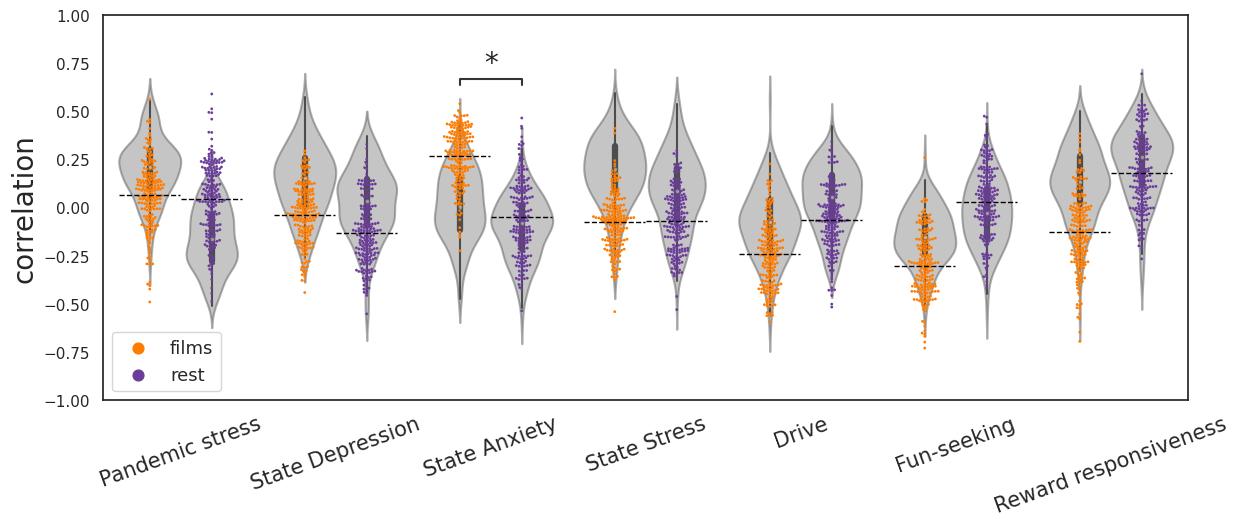

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BIG5_ope_films vs. BIG5_ope_rest: Custom statistical test, P_val:1.000e-02


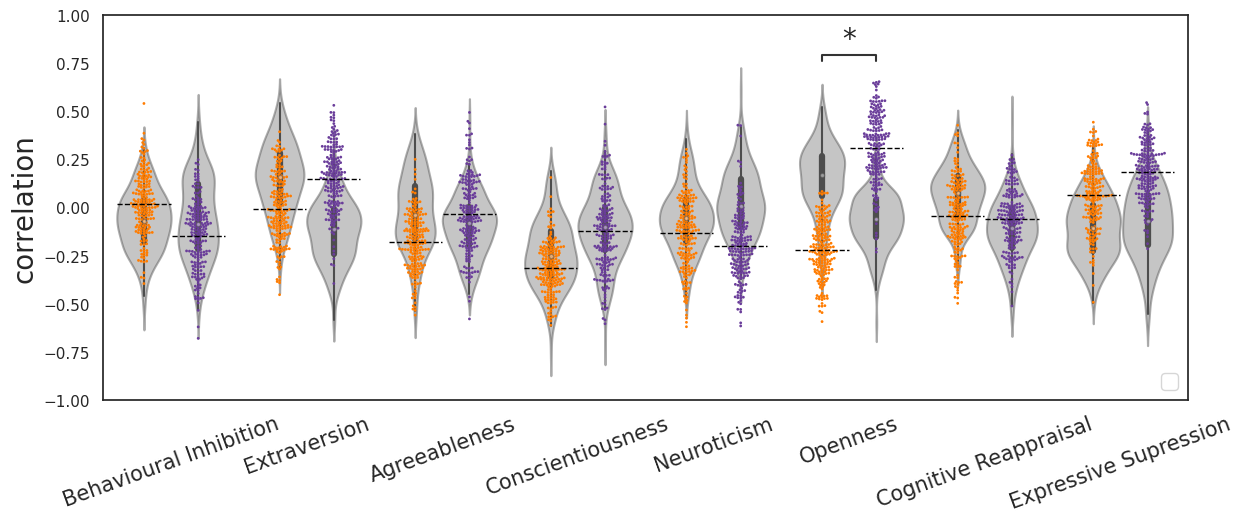

In [152]:
paired_diff = {tmppsy: [] for tmppsy in psy1+psy2}
sns.set_theme(style='white')

cur_df = pred_df

# PLOT 1
tmp_psy = [psy1,psy2]
tmp_label = [verbose1, verbose2]
for i in range(2):
    plt.figure(figsize=(14,5))

    p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(tmp_psy[i])], hue="type",
                  color="r", alpha=1, size=2, dodge=True, palette=sns.color_palette([
                      sns.color_palette("bright")[1], 
                  sns.color_palette("Paired")[9]]))

    # plot the mean line
    sns.boxplot(showmeans=True,meanline=True,medianprops={'visible': False},
                whiskerprops={'visible': False},zorder=10,x="pidx",y="corr", hue="type",
                data=cur_df[cur_df['pidx'].isin(tmp_psy[i])],
                showfliers=False,showbox=False,showcaps=False,ax=p, meanprops=dict(color="black", alpha=1))

    ax = sns.violinplot(showmeans=True,meanline=True,meanprops={'color': 'grey', 'ls': '-', 'lw': 2}
                        ,zorder=10,x="pidx",y="corr", hue="type",
                data=null_df[null_df['pidx'].isin(tmp_psy[i])],ax=p, palette=sns.color_palette(['grey', 'grey']),
                       alpha=1)


    if i == 0:
        badpred = [0,2,3] + [nx for nx in range(5,14)]
        nullplots = [nx for nx in range(16,len(ax.collections))]
        for violin in np.array(ax.collections)[nullplots]:
            violin.set_alpha(0.45)
    if i == 1:
        badpred = [0,1,2,] + [nx for nx in range(4,11)] + [12,13,14]
        nullplots = [nx for nx in range(18,len(ax.collections))]
        for violin in np.array(ax.collections)[nullplots]:
            violin.set_alpha(0.45)

    plotting_parameters = { 'data':    cur_df[cur_df['pidx'].isin(tmp_psy[i])],'x':'pidx',
                           'y':'corr','hue':'type',
                           'palette': sns.color_palette([sns.color_palette("bright")[1]
                                    , sns.color_palette("Paired")[9]])}

    pvalues = []
    pairs = []
    for psy_p in tmp_psy[i]:
        tmp = cur_df[cur_df['pidx'] == psy_p]
        arr1 = np.nan_to_num(list(tmp[tmp['type']=='films']['corr']))
        arr2 = np.nan_to_num(list(tmp[tmp['type']=='rest']['corr']))

        # shape of nonparamcorrs are (null_iter, nb_iter, 3)
        shuffle1 = np.nan_to_num(np.nanmean(non_param_corrs['S1'][psy_p], axis=-1))
        shuffle2 = np.nan_to_num(np.nanmean(non_param_corrs['S2'][psy_p], axis=-1))
        shuffle_distrib = np.nanmean((shuffle1 - shuffle2), axis=-1)
        # paired t-test
    #     pval = stats.ttest_rel(arr1, arr2).pvalue

        # randomized shuffle
        pval = null_score(shuffle_distrib, np.nanmean(arr1 - arr2))
        
        pval = min(pval, 1-pval)
        paired_diff[psy_p].append(np.round(pval,4))
        # print((psy_p,'films'), (psy_p, 'films'), pval)
        if pval >= 0.05: continue
        pvalues.append(pval)
        pairs.append(((psy_p,'films'), (psy_p, 'rest')))

    annotator = Annotator(p, pairs, **plotting_parameters)
    annotator.set_pvalues(pvalues)
    annotator.configure(loc='inside', fontsize=20)
    annotator.annotate()

    p.set_ylabel('correlation', fontsize=20)
    p.set_xlabel('', fontsize=20)
    p.set_xticklabels(tmp_label[i], fontsize=15,rotation=20)
    p.set_ylim(-1,1)

    # get rid of duplicate legends
    handles, labels = p.get_legend_handles_labels()
    if i == 0:
        p.legend(handles[:len(handles)//2-1], labels[:len(handles)//2-1], prop={'size':13}, loc='lower left')
    else:
        p.legend([], [], prop={'size':15}, loc='lower right')
        
#     plt.title("Fold repetition distribution of prediction correlations with personality indexes", fontsize=20)
    plt.show()

In [36]:
tmpdf = pd.DataFrame.from_dict(paired_diff)
tmpdf.index = ['pval']
print(tmpdf.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
{} &  cov\_total &  DASS\_dep &  DASS\_anx &  DASS\_str &  bas\_d &  bas\_f &  bas\_r &    bis &  BIG5\_ext &  BIG5\_agr &  BIG5\_con &  BIG5\_neu &  BIG5\_ope &  erq\_cr &  erq\_es \\
\midrule
pval &       0.46 &      0.35 &      0.04 &     0.475 &   0.08 &  0.065 &   0.08 &  0.275 &      0.14 &     0.075 &     0.165 &      0.42 &      0.01 &   0.495 &   0.295 \\
\bottomrule
\end{tabular}



#### Stat test and swarmplots of personality indexes of interest

('DASS_anx', 'films') ('DASS_anx', 'films') 0.04
('BIG5_ope', 'films') ('BIG5_ope', 'films') 0.99
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

DASS_anx_films vs. DASS_anx_rest: Custom statistical test, P_val:4.000e-02


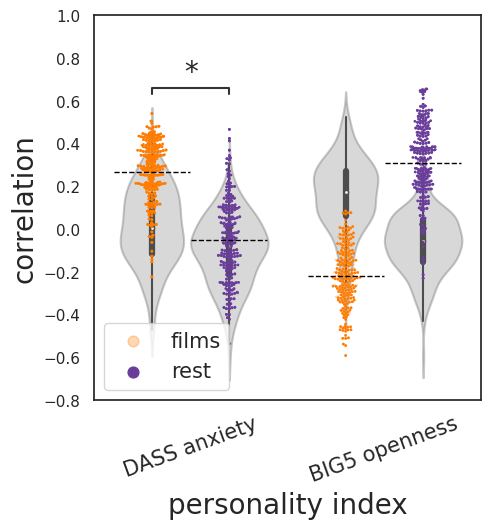

In [37]:
sns.set_theme(style='white')

cur_df = pred_df

# PLOT 1
tmp_psy = ['DASS_anx', 'BIG5_ope']
tmp_label = ['DASS anxiety', 'BIG5 openness']

plt.figure(figsize=(5,5))

p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(tmp_psy)], hue="type",
              color="r", alpha=1, size=2, dodge=True, palette=sns.color_palette([
                  sns.color_palette("bright")[1], 
              sns.color_palette("Paired")[9]]))

# plot the mean line
sns.boxplot(showmeans=True,meanline=True,medianprops={'visible': False},
            whiskerprops={'visible': False},zorder=10,x="pidx",y="corr", hue="type",
            data=cur_df[cur_df['pidx'].isin(tmp_psy)],
            showfliers=False,showbox=False,showcaps=False,ax=p, meanprops=dict(color="black", alpha=1))

ax = sns.violinplot(showmeans=True,meanline=True,meanprops={'color': 'grey', 'ls': '-', 'lw': 2}
                    ,zorder=10,x="pidx",y="corr", hue="type",
            data=null_df[null_df['pidx'].isin(tmp_psy)],ax=p, palette=sns.color_palette(['grey', 'grey']),
                   alpha=1)
for violin in np.array(ax.collections)[[i+2 for i in range(0,len(ax.collections)-2,2)]]:
    violin.set_alpha(0.3)
p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(tmp_psy)], hue="type",
              color="r", alpha=1, size=2, dodge=True, palette=sns.color_palette([
                  sns.color_palette("bright")[1], 
              sns.color_palette("Paired")[9]]))

plotting_parameters = { 'data':    cur_df[cur_df['pidx'].isin(tmp_psy)],'x':'pidx',
                       'y':'corr','hue':'type','palette': sns.color_palette([sns.color_palette("bright")[1]
                                                                             , sns.color_palette("Paired")[9]])}

pvalues = []
pairs = []
for psy_p in tmp_psy:
    tmp = cur_df[cur_df['pidx'] == psy_p]
    arr1 = np.nan_to_num(list(tmp[tmp['type']=='films']['corr']))
    arr2 = np.nan_to_num(list(tmp[tmp['type']=='rest']['corr']))

    # shape of nonparamcorrs are (null_iter, nb_iter, 3)
    shuffle1 = np.nan_to_num(np.nanmean(non_param_corrs['S1'][psy_p], axis=-1))
    shuffle2 = np.nan_to_num(np.nanmean(non_param_corrs['S2'][psy_p], axis=-1))
    shuffle_distrib = np.nanmean((shuffle1 - shuffle2), axis=-1)
    # paired t-test
#     pval = stats.ttest_rel(arr1, arr2).pvalue

    # randomized shuffle
    pval = null_score(shuffle_distrib, np.nanmean(arr1 - arr2))
    print((psy_p,'films'), (psy_p, 'films'), pval)
    if pval >= 0.05: continue
    pvalues.append(pval)
    pairs.append(((psy_p,'films'), (psy_p, 'rest')))

annotator = Annotator(p, pairs, **plotting_parameters)
annotator.set_pvalues(pvalues)
annotator.configure(loc='inside', fontsize=20)
annotator.annotate()

p.set_ylabel('correlation', fontsize=20)
p.set_xlabel('personality index', fontsize=20)
p.set_xticklabels(tmp_label, fontsize=15,rotation=20)
p.set_ylim(-0.8,1)

# get rid of duplicate legends
handles, labels = p.get_legend_handles_labels()
p.legend(handles[:len(handles)//2-2], labels[:len(handles)//2-2], prop={'size':15}, loc=3)
# plt.title("Fold repetition distribution of prediction correlations with personality indexes", fontsize=20)
plt.show()

<a class="anchor" id="fselect-staticgrad-focus"></a>
## On frame selected Static Gradients (focusing on selected pidx and meaning of pidx)

In [38]:
cur_psy = ['DASS_anx', 'BIG5_ope']

In [39]:
fselect_supermovie_grads = load('./resources/fselect_grads/fa_scores_withID/fglobal_cross_grads_supermovie_withID_val-aro_bin25.pkl')

In [20]:
subjects = list(fselect_supermovie_grads[0][(0,25,25,50)].keys())
nsub = len(subjects)

# extract from all gradients the parcel wise distance to centroid as feature
fselect_supermovie_dists = {}
for fa_nb in range(1):
    tmp_fa = fselect_supermovie_grads[fa_nb]
    per_bound = {}
    for bound in tmp_fa:
        tmp_bounds = tmp_fa[bound]
        if len(tmp_bounds) == 0: continue
            
        tmp_dist = {}
        for _id in subjects:
            tmp_grads = tmp_bounds[_id]
            dist = D(tmp_grads.mean(axis=0), tmp_grads)
            tmp_dist[_id] = dist
            
        per_bound[bound] = tmp_dist

    fselect_supermovie_dists[fa_nb] = per_bound

In [21]:
n_iter = 250 #number of repetitions of nested cross val
# search grid for hyper parameter
lambda_grid = [10**(i) for i in range(-3,4)] + [5] + [20] + [30] + [50]
combination_k = list(fselect_supermovie_dists[0].keys())

np.random.seed(99)
for fa_nb in range(1):
    tmp_fa = fselect_supermovie_dists[fa_nb]
    
    pred_corrs = {key: {} for key in combination_k}
    null_corrs = {key: {} for key in combination_k}
    for gidx, gtype in enumerate(tqdm(pred_corrs.keys())):
       
        # across all pidx
        for feat in tqdm(cur_psy):
            psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
            X = np.asarray([tmp_fa[gtype][subj] for subj in subjects])
            y = np.array(deepcopy(psyscore))
            yshuffle = deepcopy(y)
            np.random.shuffle(yshuffle)

            pred_corrs[gtype][feat] = compute_outer_fold_and_weights(X,y, n_iter, lambda_grid, scoring_method)
            null_corrs[gtype][feat] = compute_outer_fold(X,yshuffle, n_iter, lambda_grid, scoring_method)
            
    pred_stats = {'pred_corrs': pred_corrs, 'null_corrs': null_corrs}
    save('./resources/regression_logs/fselect_cross_globalbin25_fa_val-aro_lasso_weight.pkl', pred_stats)

hide()

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [40]:
cur_psy = ['DASS_anx', 'BIG5_ope']

stand_corrs = load('./resources/regression_logs/supermovie-rest_lasso.pkl')['pred_corrs']
stand_null_corrs = load('./resources/regression_logs/supermovie-rest_lasso.pkl')['null_corrs']

In [ ]:
# # val-arousal
# pred_stats = load('./resources/regression_logs/fselect_cross_globalbin25_val-aro0_lasso.pkl')

# pred_corrs = pred_stats['pred_corrs']
# null_corrs = pred_stats['null_corrs']

# B1 = list(pred_corrs.keys())
# pred_df1, null_df1 = format_results2df(B1, pred_corrs, stand_corrs, null_corrs, stand_null_corrs, cur_psy)


# # val-power
# pred_stats = load('./resources/regression_logs/fselect_cross_globalbin25_val-pow0_lasso.pkl')

# pred_corrs = pred_stats['pred_corrs']
# null_corrs = pred_stats['null_corrs']

# B2 = list(pred_corrs.keys())
# pred_df2, null_df2 = format_results2df(B2, pred_corrs, stand_corrs, null_corrs, stand_null_corrs, cur_psy)

# # arousal-power
# pred_stats = load('./resources/regression_logs/fselect_cross_globalbin25_aro-pow0_lasso.pkl')

# pred_corrs = pred_stats['pred_corrs']
# null_corrs = pred_stats['null_corrs']

# B3 = list(pred_corrs.keys())
# pred_df3, null_df3 = format_results2df(B3, pred_corrs, stand_corrs, null_corrs, stand_null_corrs, cur_psy)

##### Small piece of code to convert the lasso weight and results into a results only dictionary used for the plotting later

In [138]:
# tmp = load('./resources/regression_logs/fselect_cross_globalbin25_fa_aro-pow_lasso_weight.pkl')

# tmp_bounds = tmp['pred_corrs'].keys()
# tmp2 = {'pred_corrs': {}, 'null_corrs': {}}
# for t1 in tmp2:
#     for t2 in tmp_bounds:
#         if t1 == 'pred_corrs':
#             tmp_dict = {'DASS_anx': tmp[t1][t2]['DASS_anx'][0], 'BIG5_ope': tmp[t1][t2]['BIG5_ope'][0]}
#         else:
#             tmp_dict = {'DASS_anx': tmp[t1][t2]['DASS_anx'], 'BIG5_ope': tmp[t1][t2]['BIG5_ope']}
#         tmp2[t1][t2] = tmp_dict
        
# save('./resources/regression_logs/fselect_cross_globalbin25_fa_aro-pow_lasso.pkl', tmp2)

In [127]:
# val-arousal
pred_stats = load('./resources/regression_logs/fselect_cross_globalbin25_fa_val-aro_lasso_weight.pkl')
pred_stats = deepcopy(tmp2)

pred_corrs = pred_stats['pred_corrs']
null_corrs = pred_stats['null_corrs']

B1 = list(pred_corrs.keys())
pred_df1, null_df1 = format_results2df(B1, pred_corrs, stand_corrs, null_corrs, stand_null_corrs, cur_psy)


# val-power
pred_stats = load('./resources/regression_logs/fselect_cross_globalbin25_val-pow0_lasso.pkl')

pred_corrs = pred_stats['pred_corrs']
null_corrs = pred_stats['null_corrs']

B2 = list(pred_corrs.keys())
pred_df2, null_df2 = format_results2df(B2, pred_corrs, stand_corrs, null_corrs, stand_null_corrs, cur_psy)

# arousal-power
pred_stats = load('./resources/regression_logs/fselect_cross_globalbin25_aro-pow0_lasso.pkl')

pred_corrs = pred_stats['pred_corrs']
null_corrs = pred_stats['null_corrs']

B3 = list(pred_corrs.keys())
pred_df3, null_df3 = format_results2df(B3, pred_corrs, stand_corrs, null_corrs, stand_null_corrs, cur_psy)

FileNotFoundError: [Errno 2] No such file or directory: './resources/regression_logs/fselect_cross_globalbin25_val-pow0_lasso.pkl'

### Visualizing Trained Weights

In [ ]:
best_weights1 = fold_weightings_lasso(pred_weights1[(20,40,40,60)]['DASS_anx']).mean(axis=0)
best_weights2 = fold_weightings_lasso(pred_weights1[(0,20,40,60)]['BIG5_ope']).mean(axis=0)

# weight counts
cbest_weights1 = fold_weightings_lasso(pred_weights1[(20,40,40,60)]['DASS_anx'])
cbest_weights1 = np.sum(cbest_weights1 != 0, axis=0)
cbest_weights2 = fold_weightings_lasso(pred_weights1[(0,20,40,60)]['BIG5_ope'])
cbest_weights2 = np.sum(cbest_weights2 != 0, axis=0)

In [ ]:
# Parcellation 400
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()

mask = labeling != 0
gs   = [cbest_weights1/1.0, cbest_weights2/1.0]

bounds = [(np.concatenate(gs).min(), np.concatenate(gs).max())]
grad = [None] * 2
for i in range(2):
        # map the gradient to the parcels
        grad[i] = map_to_labels(gs[i][:400], labeling, mask=mask, fill=np.nan)


paths = ['../figures/dass_anx_weights_bin20_count.jpg', '../figures/big5_ope_weights_bin20_count.jpg']
for i in range(2):
        plot_hemispheres(surf_lh, surf_rh, array_name=[grad[i]], size=(550, 450), cmap='hot', layout_style="grid",
                color_bar=True, label_text=[''], zoom=.9, embed_nb=True, interactive=False, screenshot=True, filename=paths[i],
                transparent_bg=False)

# Subcorticals
from enigmatoolbox.plotting import plot_subcortical
with open('./data/labels/TC_sub14_labels.csv') as f:
    text = f.readlines()
    text = [t.strip() for t in text]

order = "left-accumbens, left-amygdala, left-caudate, left-hippocampus, left-pallidum, left-putamen, left-thalamus, right-accumbens, right-amygdala, right-caudate, right-hippocampus, right-pallidum, right-putamen, right-thalamus".split(',')
order = [' '.join(o.split('-')).strip() for o in order]
dataorder = [t.lower() for t in text]
orderidx = [order.index(o) for o in dataorder]

# "color-range" flag can be used if needed very useful instead of artificially
# Project the results on the surface brain
paths = ['../figures/dass_anx_weights_bin20_subcort.jpg', '../figures/big5_ope_weights_bin20_subcort.jpg']
for k in range(2):
    plot_subcortical(array_name=gs[k][400:][orderidx], ventricles=False, size=(800, 400),color_range=bounds,
                    cmap='bwr', color_bar=True, embed_nb=False, label_text=['rest sub'], interactive=False, transparent_bg=False,
                    screenshot=True, filename=paths[k])

### Plot marginals of prediction along one 3FA

In [40]:
valence_stats = load('./resources/regression_logs/fselect_global_fa0_lasso.pkl')
arousal_stats = load('./resources/regression_logs/fselect_global_fa1_lasso.pkl')
power_stats = load('./resources/regression_logs/fselect_global_fa2_lasso.pkl')

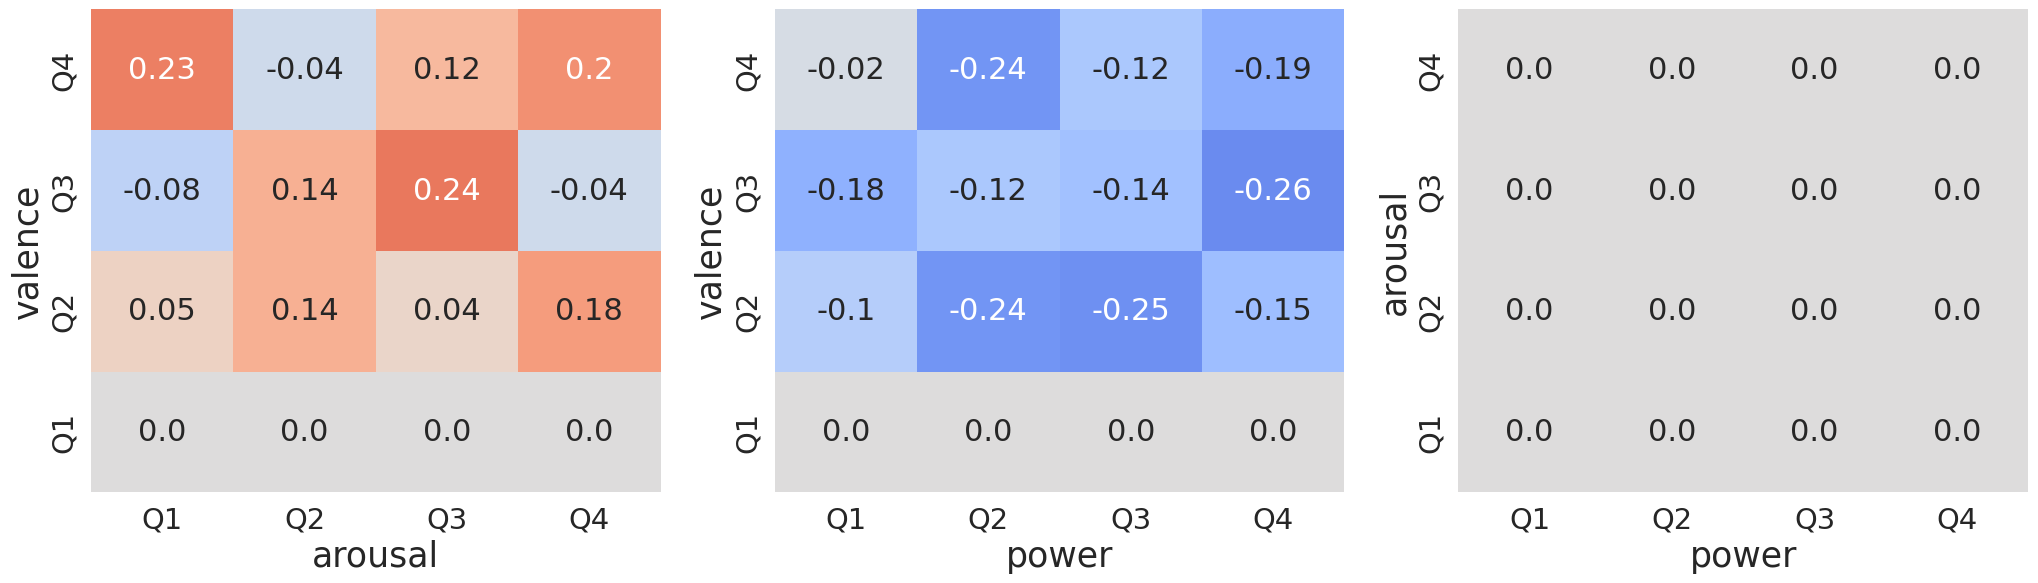

In [32]:
m1 = np.array([np.mean(valence_stats['pred_corrs'][s]['DASS_anx']) for s in s25])
m2 = np.array([np.mean(arousal_stats['pred_corrs'][s]['DASS_anx']) for s in s25])
m3 = np.array([np.mean(power_stats['pred_corrs'][s]['DASS_anx']) for s in s25])
dass_anx_marg = np.stack([m1,m2,m3, np.zeros_like(m1)])

m1 = np.array([np.mean(valence_stats['pred_corrs'][s]['BIG5_ope']) for s in s25])
m2 = np.array([np.mean(arousal_stats['pred_corrs'][s]['BIG5_ope']) for s in s25])
m3 = np.array([np.mean(power_stats['pred_corrs'][s]['BIG5_ope']) for s in s25])
big5_ope_marg = np.stack([m1,m2,m3, np.zeros_like(m1)])

fig, ax = plt.subplots(1,3,figsize=(25,7))

norm = mcolors.Normalize(-0.37, 0.37)

import seaborn as sns
sns.set(font_scale=1.9)

labels = [('valence', 'arousal'), ('valence','power'), ('arousal','power')]
tickslabels = ['Q1', 'Q2', 'Q3','Q4']

pred_grids = [dass_anx_marg, big5_ope_marg, np.zeros_like(dass_anx_marg)]
for k in range(3):

    sns.heatmap(np.round(pred_grids[k],2) , annot=True, xticklabels=tickslabels, yticklabels=tickslabels[::-1], 
                ax=ax[k], cmap='coolwarm', annot_kws={"fontsize":22},
                norm=norm, cbar=False, fmt='')

    ax[k].set_xlabel(labels[k][1], fontsize=25)
    ax[k].set_ylabel(labels[k][0], fontsize=25)
    
fig.subplots_adjust(top=0.8)

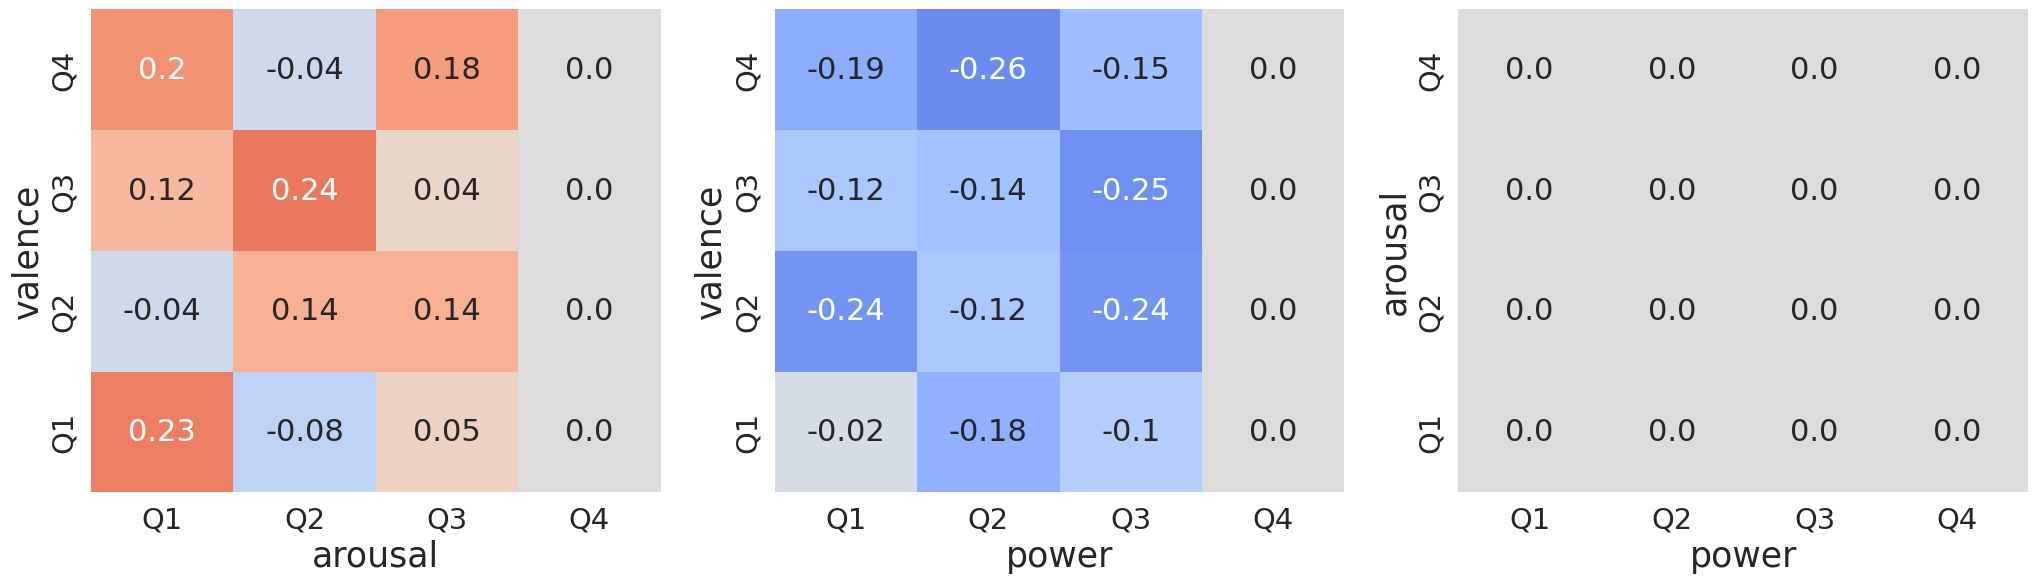

In [35]:
fig, ax = plt.subplots(1,3,figsize=(25,7))

import seaborn as sns
sns.set(font_scale=1.9)

pred_grids = [dass_anx_marg, big5_ope_marg, np.zeros_like(dass_anx_marg)]
for k in range(3):

    sns.heatmap(np.round(pred_grids[k],2).T[::-1] , annot=True, xticklabels=tickslabels, yticklabels=tickslabels[::-1], 
                ax=ax[k], cmap='coolwarm', annot_kws={"fontsize":22},
                norm=norm, cbar=False, fmt='')

    ax[k].set_xlabel(labels[k][1], fontsize=25)
    ax[k].set_ylabel(labels[k][0], fontsize=25)
    
fig.subplots_adjust(top=0.8)

### Intersection of quartiles prediction

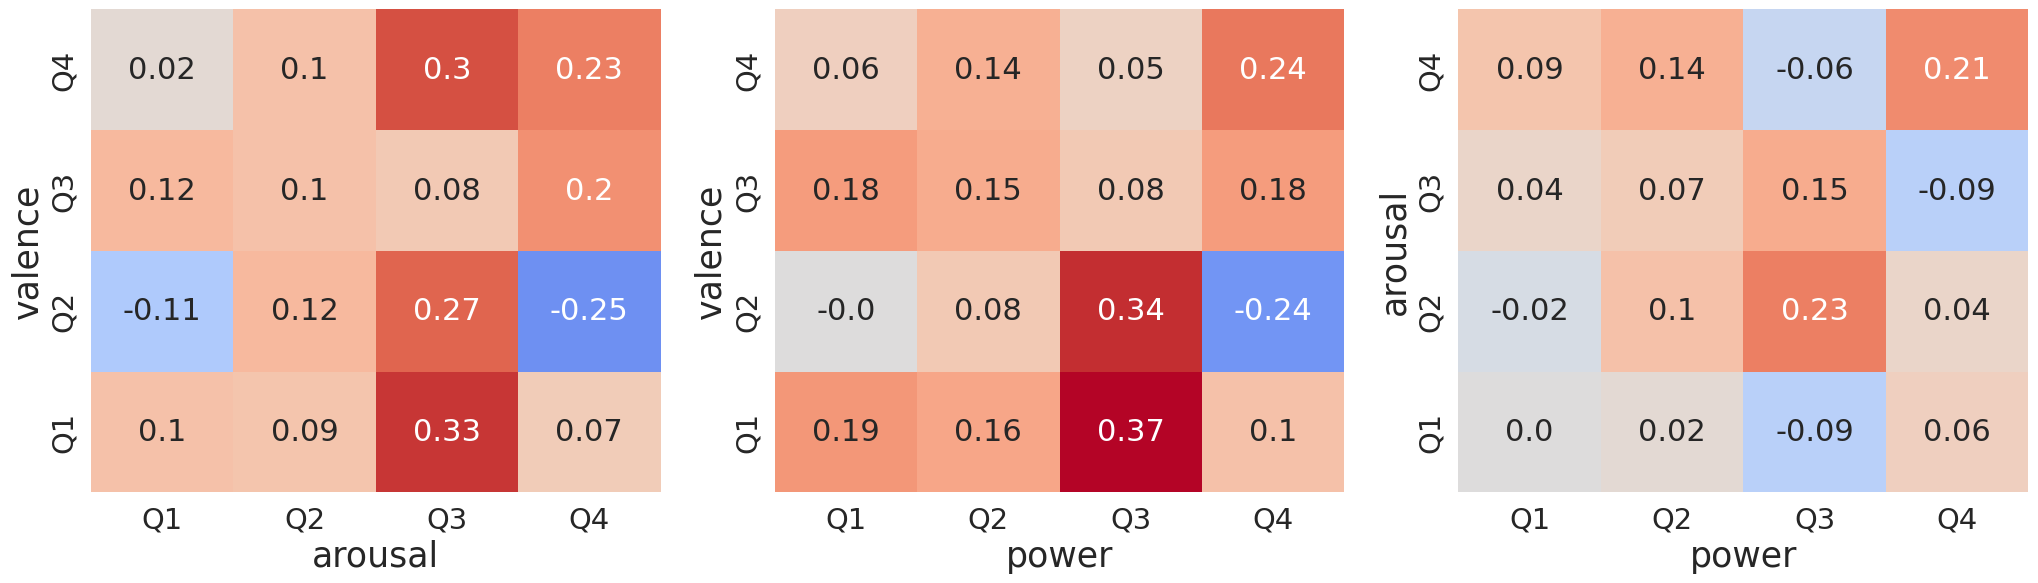

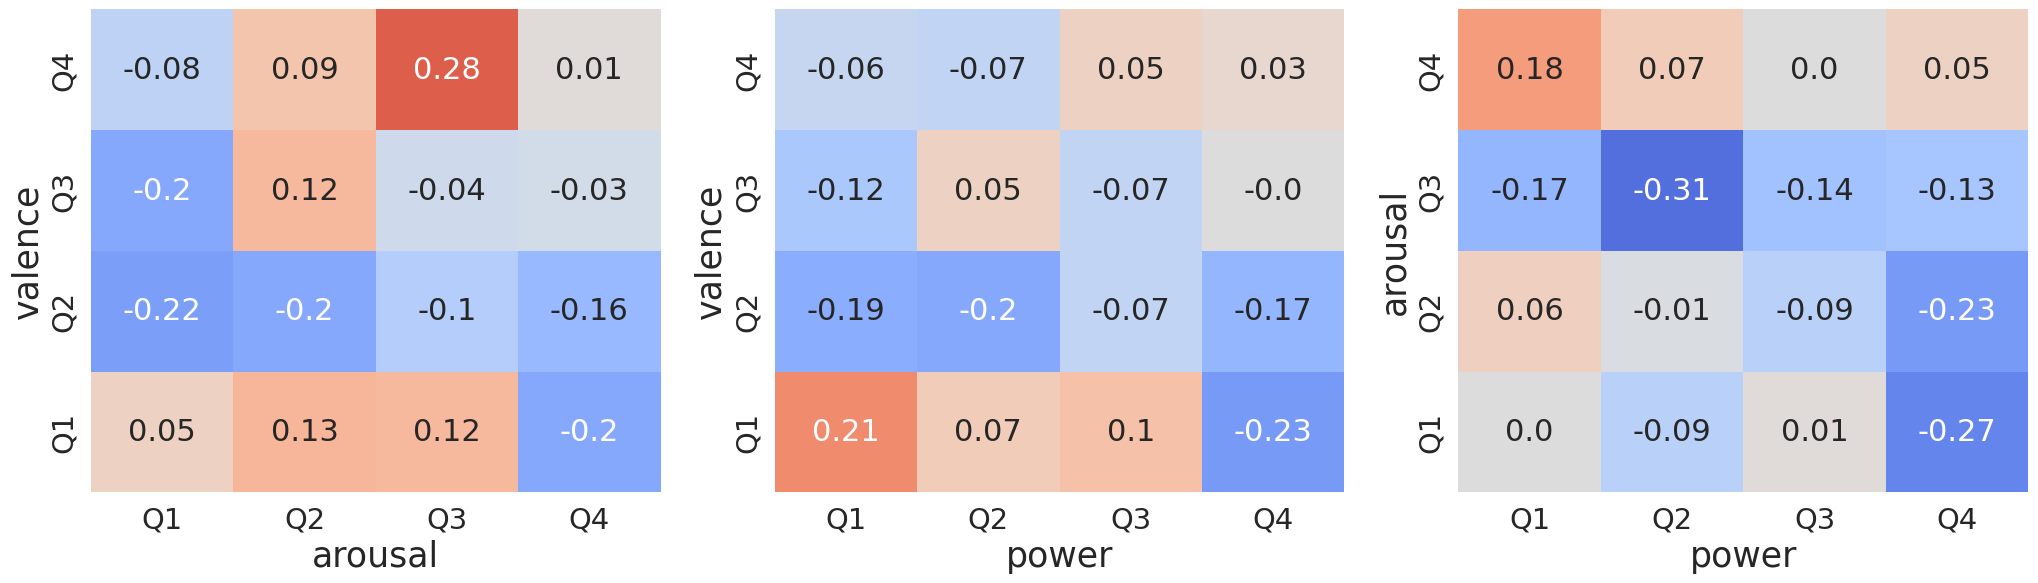

In [34]:
import matplotlib.colors as mcolors

for tmp_psy in ['DASS_anx', 'BIG5_ope']:
    modal_df1 = pred_df1[pred_df1['pidx']==tmp_psy]
    modal_df2 = pred_df2[pred_df2['pidx']==tmp_psy]
    modal_df3 = pred_df3[pred_df3['pidx']==tmp_psy]

    fig, ax = plt.subplots(1,3,figsize=(25,7))
    pgrids = []
    vgrids = []
    modals = [modal_df1, modal_df2, modal_df3]
    labels = [('valence', 'arousal'), ('valence','power'), ('arousal','power')]
    titlelabels = ['V/A', 'V/P', 'A/P']
    norm = mcolors.Normalize(-0.37, 0.37)

    tickslabels = ['Q1', 'Q2', 'Q3','Q4']

    import seaborn as sns
    sns.set(font_scale=1.9)

    for k in range(3):
        pred_grid = np.zeros((len(s25),len(s25)))
        variation_grid = np.zeros((len(s25),len(s25)))
        for _type in modals[k].type.unique():
            if _type in ['rest','movie']: continue
            x,y = percentile2coord(_type, s25)
            pred_grid[x,y] = modals[k][modals[k]['type']==_type]['corr'].mean()
            variation_grid[x,y] = modals[k][modals[k]['type']==_type]['corr'].std()

        pred_grid = np.round(pred_grid,2)
        variation_grid = np.round(variation_grid,2)
        pgrids.append(pred_grid)
        vgrids.append(variation_grid)

        sns.heatmap(pred_grid[::-1] , annot=True, xticklabels=tickslabels, yticklabels=tickslabels[::-1], 
                    ax=ax[k], cmap='coolwarm', annot_kws={"fontsize":22},
                    norm=norm, cbar=False, fmt='')

        ax[k].set_xlabel(labels[k][1], fontsize=25)
        ax[k].set_ylabel(labels[k][0], fontsize=25)


    # save('dass_anx_predgrid.pkl', pgrids)
    fig.subplots_adjust(top=0.8)
    # fig.suptitle('Fold Mean Prediction for {}'.format('DASS Anxiety'), fontsize=30)

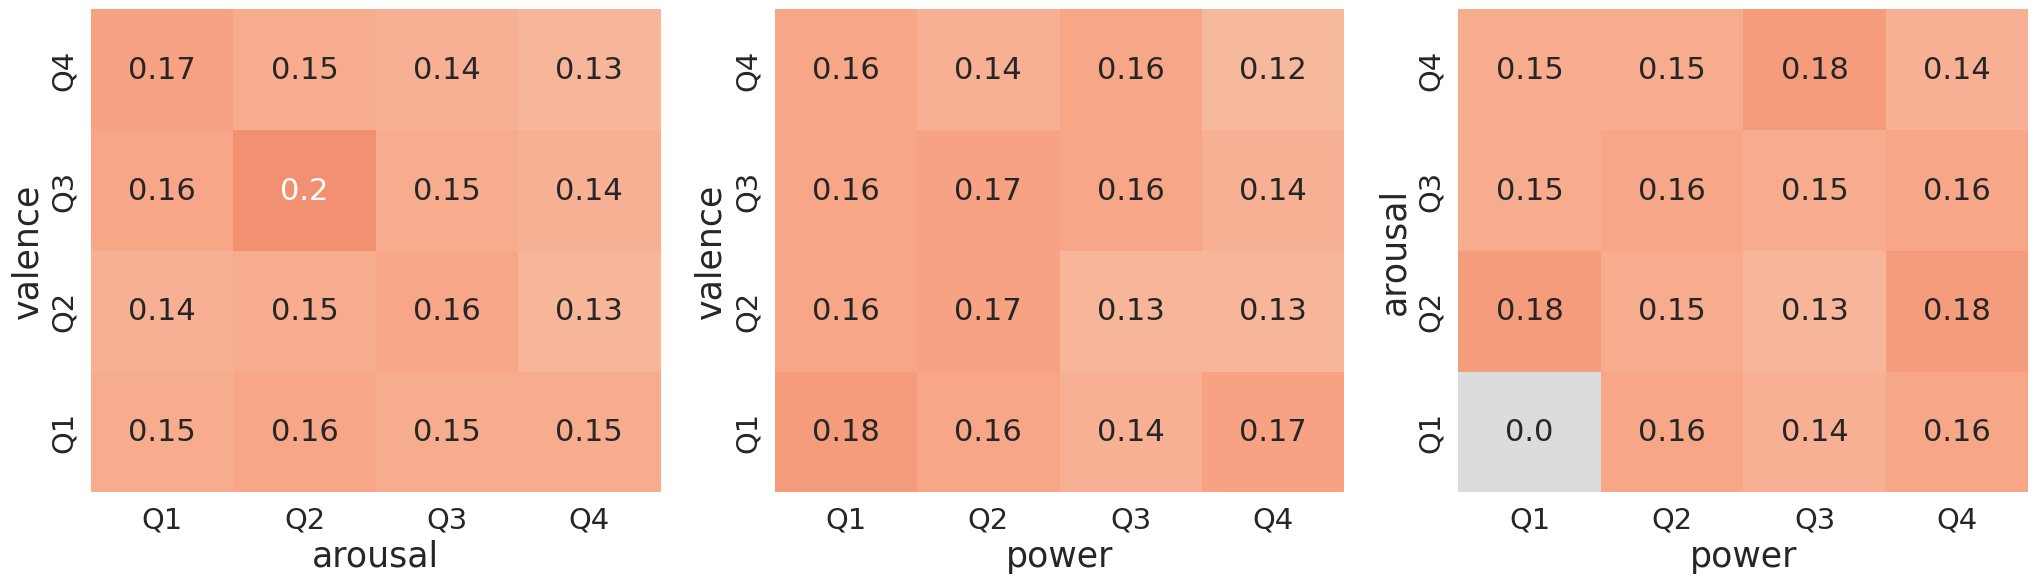

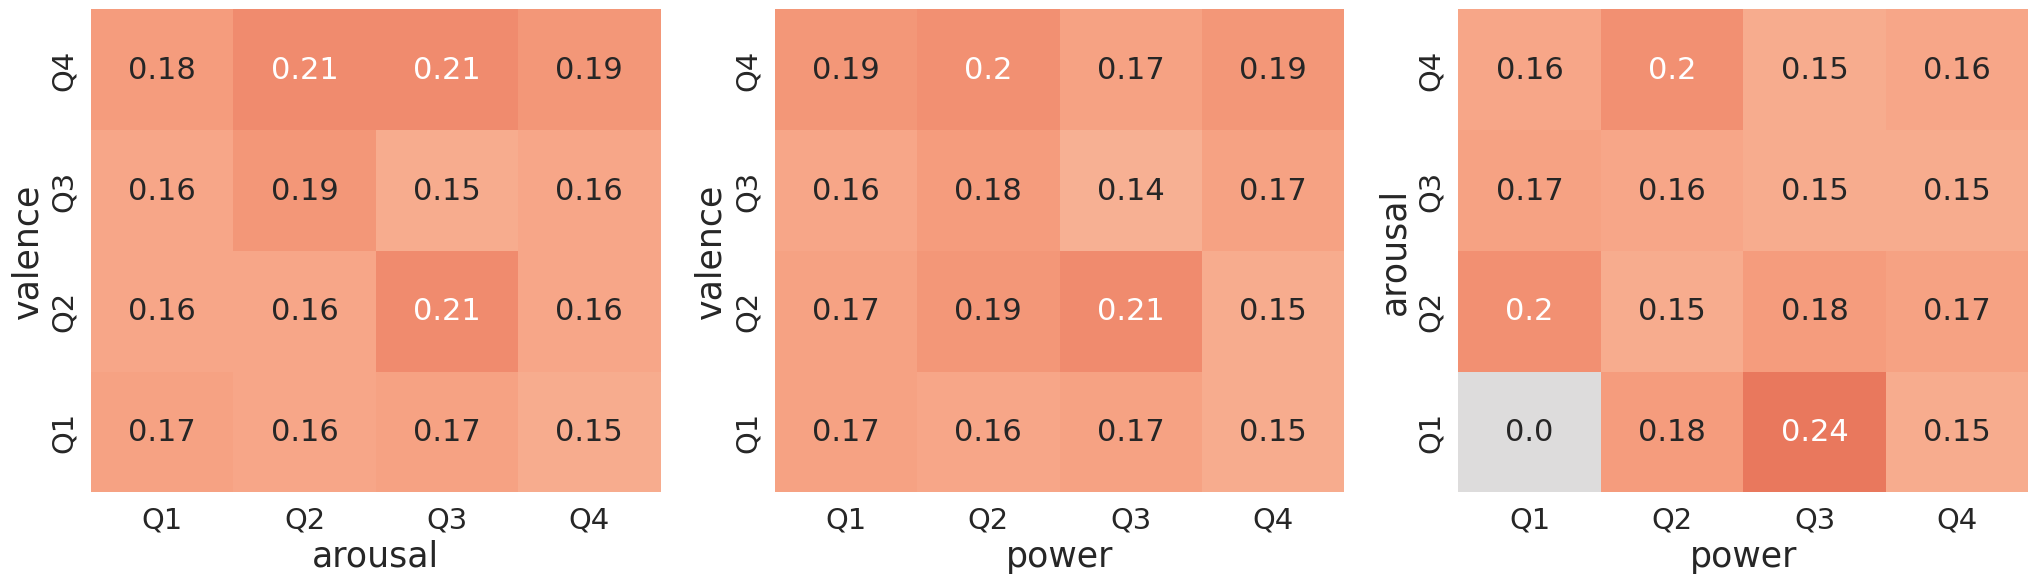

In [43]:
import matplotlib.colors as mcolors

for tmp_psy in ['DASS_anx', 'BIG5_ope']:
    modal_df1 = pred_df1[pred_df1['pidx']==tmp_psy]
    modal_df2 = pred_df2[pred_df2['pidx']==tmp_psy]
    modal_df3 = pred_df3[pred_df3['pidx']==tmp_psy]

    fig, ax = plt.subplots(1,3,figsize=(25,7))
    pgrids = []
    vgrids = []
    modals = [modal_df1, modal_df2, modal_df3]
    labels = [('valence', 'arousal'), ('valence','power'), ('arousal','power')]
    titlelabels = ['V/A', 'V/P', 'A/P']
    norm = mcolors.Normalize(-0.37, 0.37)

    tickslabels = ['Q1', 'Q2', 'Q3','Q4']

    import seaborn as sns
    sns.set(font_scale=1.9)

    for k in range(3):
        pred_grid = np.zeros((len(s25),len(s25)))
        variation_grid = np.zeros((len(s25),len(s25)))
        for _type in modals[k].type.unique():
            if _type in ['rest','movie']: continue
            x,y = percentile2coord(_type, s25)
            pred_grid[x,y] = modals[k][modals[k]['type']==_type]['corr'].mean()
            variation_grid[x,y] = modals[k][modals[k]['type']==_type]['corr'].std()

        pred_grid = np.round(pred_grid,2)
        variation_grid = np.round(variation_grid,2)
        pgrids.append(pred_grid)
        vgrids.append(variation_grid)

        sns.heatmap(variation_grid[::-1] , annot=True, xticklabels=tickslabels, yticklabels=tickslabels[::-1], 
                    ax=ax[k], cmap='coolwarm', annot_kws={"fontsize":22},
                    norm=norm, cbar=False, fmt='')

        ax[k].set_xlabel(labels[k][1], fontsize=25)
        ax[k].set_ylabel(labels[k][0], fontsize=25)


    # save('dass_anx_predgrid.pkl', pgrids)
    fig.subplots_adjust(top=0.8)
    # fig.suptitle('Fold Mean Prediction for {}'.format('DASS Anxiety'), fontsize=30)

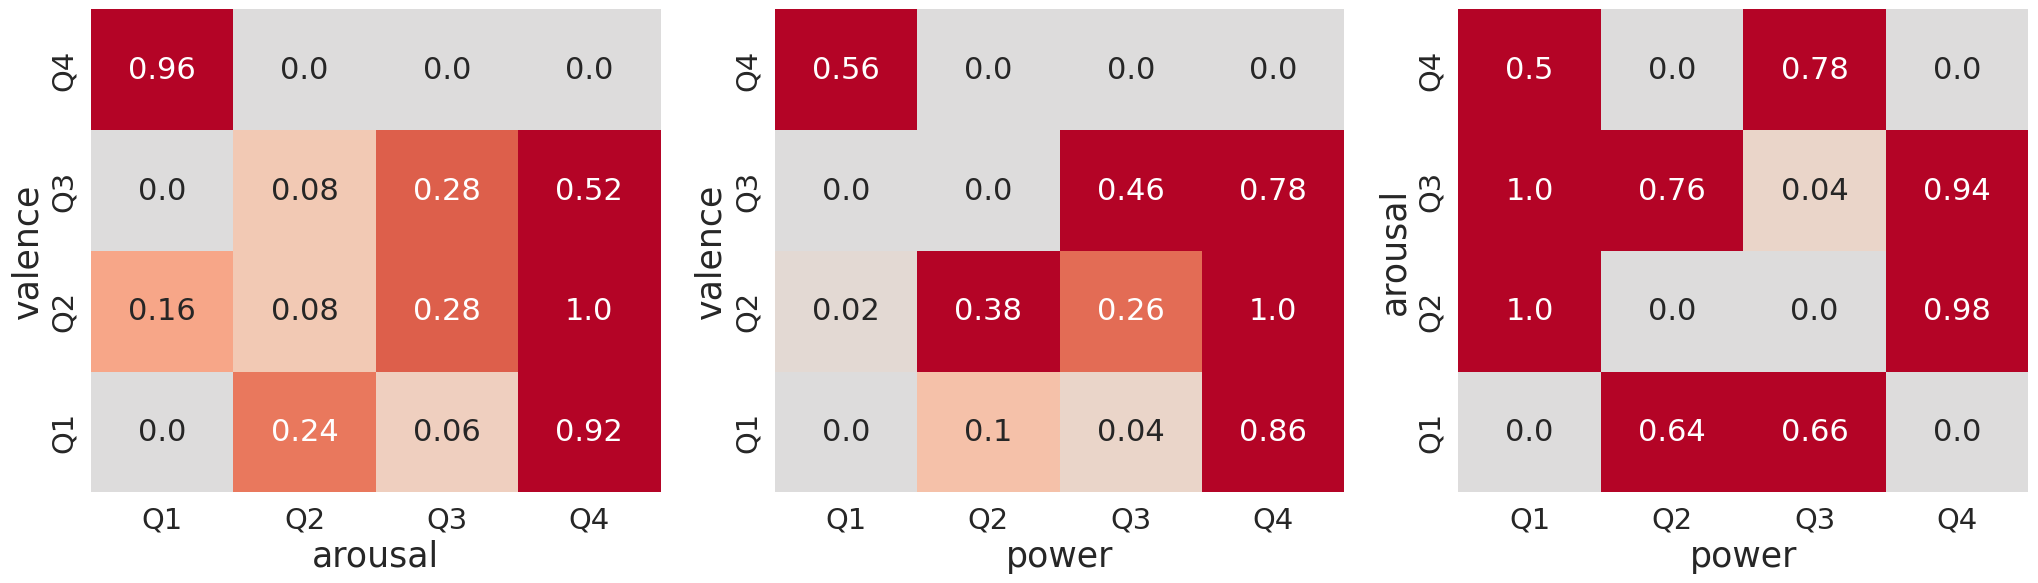

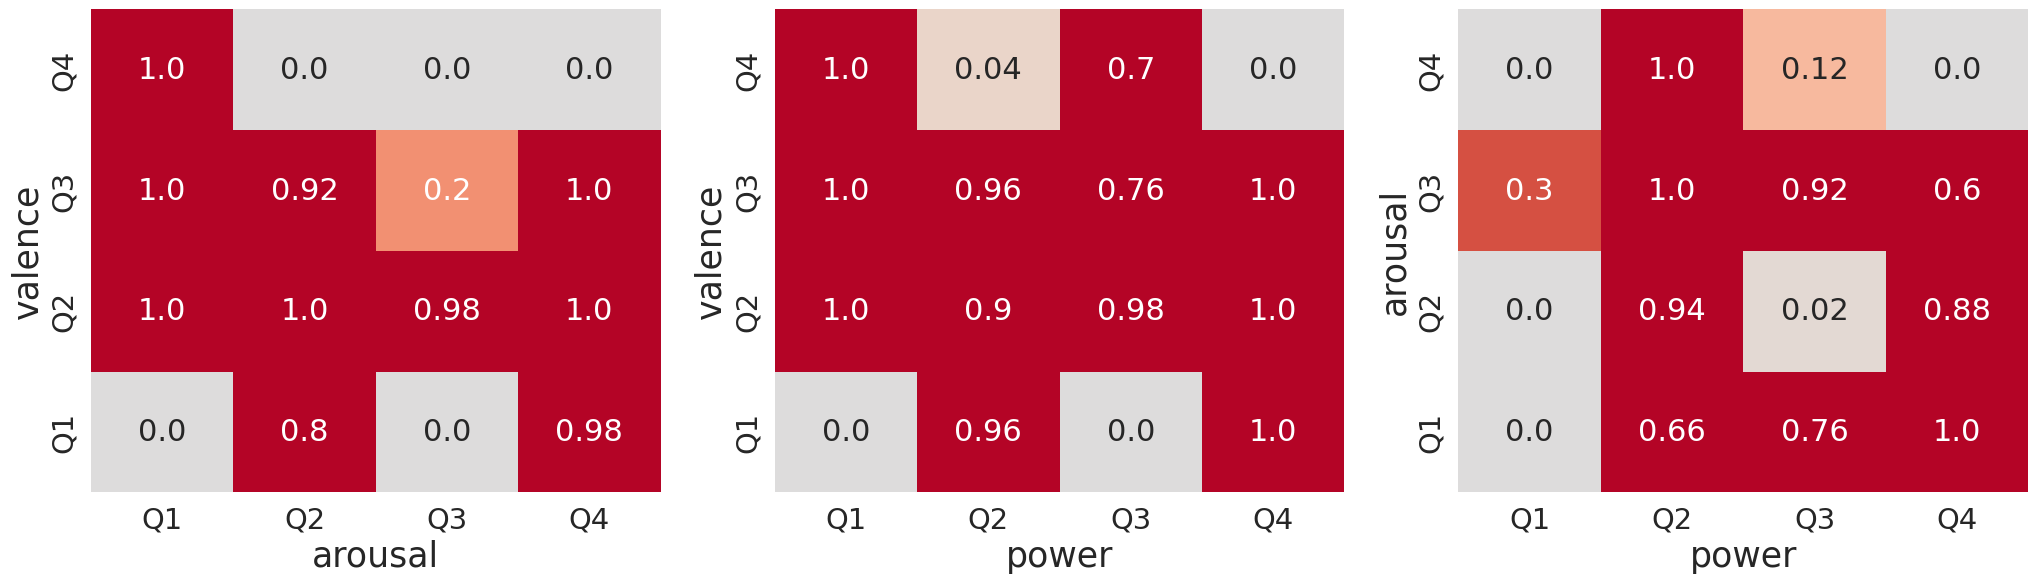

In [57]:
import matplotlib.colors as mcolors

for tmp_psy in ['DASS_anx', 'BIG5_ope']:
    modal_df1 = pred_df1[pred_df1['pidx']==tmp_psy]
    modal_df2 = pred_df2[pred_df2['pidx']==tmp_psy]
    modal_df3 = pred_df3[pred_df3['pidx']==tmp_psy]

    nmodal_df1 = null_df1[null_df1['pidx']==tmp_psy]
    nmodal_df2 = null_df2[null_df2['pidx']==tmp_psy]
    nmodal_df3 = null_df3[null_df3['pidx']==tmp_psy]
    
    fig, ax = plt.subplots(1,3,figsize=(25,7))
    pgrids = []
    vgrids = []
    modals = [modal_df1, modal_df2, modal_df3]
    nmodals = [nmodal_df1, nmodal_df2, nmodal_df3]
    labels = [('valence', 'arousal'), ('valence','power'), ('arousal','power')]
    titlelabels = ['V/A', 'V/P', 'A/P']
    norm = mcolors.Normalize(-0.37, 0.37)

    tickslabels = ['Q1', 'Q2', 'Q3','Q4']

    import seaborn as sns
    sns.set(font_scale=1.9)

    for k in range(3):
        pval_grid = np.zeros((len(s25),len(s25)))
        for _type in modals[k].type.unique():
            if _type in ['rest','movie']: continue
            x,y = percentile2coord(_type, s25)
            init_stat = modals[k][modals[k]['type']==_type]['corr'].mean()
            null_stat = np.array(list(nmodals[k][nmodals[k]['type']==_type]['corr']))
            
            pval_grid[x,y] = null_score(null_stat.reshape(-1,5).mean(axis=1), init_stat)

        pval_grid = np.round(pval_grid,2)

        sns.heatmap(pval_grid[::-1] , annot=True, xticklabels=tickslabels, yticklabels=tickslabels[::-1], 
                    ax=ax[k], cmap='coolwarm', annot_kws={"fontsize":22},
                    norm=norm, cbar=False, fmt='')

        ax[k].set_xlabel(labels[k][1], fontsize=25)
        ax[k].set_ylabel(labels[k][0], fontsize=25)


    # save('dass_anx_predgrid.pkl', pgrids)
    fig.subplots_adjust(top=0.8)
    # fig.suptitle('Fold Mean Prediction for {}'.format('DASS Anxiety'), fontsize=30)

<a class="anchor" id="fselect-staticgrad"></a>
## On frame selected Static Gradients global thresholding 3FA

In [22]:
fselect_supermovie_grads = load('./resources/fselect_grads/fa_scores_withID/fselected_global_grads_supermovie_withID.pkl')

In [25]:
subjects = list(fselect_supermovie_grads[0][(0,25)].keys())
nsub = len(subjects)

# extract from all gradients the parcel wise distance to centroid as feature
fselect_supermovie_dists = {}
for fa_nb in range(3):
    tmp_fa = fselect_supermovie_grads[fa_nb]
    per_bound = {}
    for bound in tmp_fa:
        tmp_bounds = tmp_fa[bound]
        
        tmp_dist = {}
        for _id in subjects:
            tmp_grads = tmp_bounds[_id]
            dist = D(tmp_grads.mean(axis=0), tmp_grads)
            tmp_dist[_id] = dist
            
        per_bound[bound] = tmp_dist

    fselect_supermovie_dists[fa_nb] = per_bound

In [ ]:
n_iter = 250 #number of repetitions of nested cross val
# search grid for hyper parameter
lambda_grid = [10**(i) for i in range(-3,4)] + [5] + [20] + [30] + [50]

# # across all FA(s)
for fa_nb in range(3):
    tmp_fa = fselect_supermovie_dists[fa_nb]
    
    pred_corrs = {key: {} for key in s25}
    null_corrs = {key: {} for key in s25}
    for gidx, gtype in enumerate(tqdm(pred_corrs.keys())):
       
        # across all pidx
        for feat in tqdm(existing_psy):
            psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]
            X = np.asarray([tmp_fa[gtype][subj] for subj in subjects])
            y = np.array(deepcopy(psyscore))
            yshuffle = deepcopy(y)
            np.random.shuffle(yshuffle)

            pred_corrs[gtype][feat] = compute_outer_fold(X,y, n_iter, lambda_grid, scoring_method)
            null_corrs[gtype][feat] = compute_outer_fold(X,yshuffle, n_iter, lambda_grid, scoring_method)
            
    pred_stats = {'pred_corrs': pred_corrs, 'null_corrs': null_corrs}
    save('./resources/regression_logs/fselect_global_fa{}_lasso.pkl'.format(fa_nb), pred_stats)

hide()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [391]:
pred_stats = load('./resources/regression_logs/fselect_global_fa0_lasso.pkl')

pred_corrs = pred_stats['pred_corrs']
null_corrs = pred_stats['null_corrs']

stand_corrs = load('./resources/regression_logs/supermovie-rest_lasso.pkl')['pred_corrs']
stand_null_corrs = load('./resources/regression_logs/supermovie-rest_lasso.pkl')['null_corrs']

B = deepcopy(s25)
pred_df, null_df = format_results2df(B, pred_corrs, stand_corrs, null_corrs, stand_null_corrs, existing_psy)

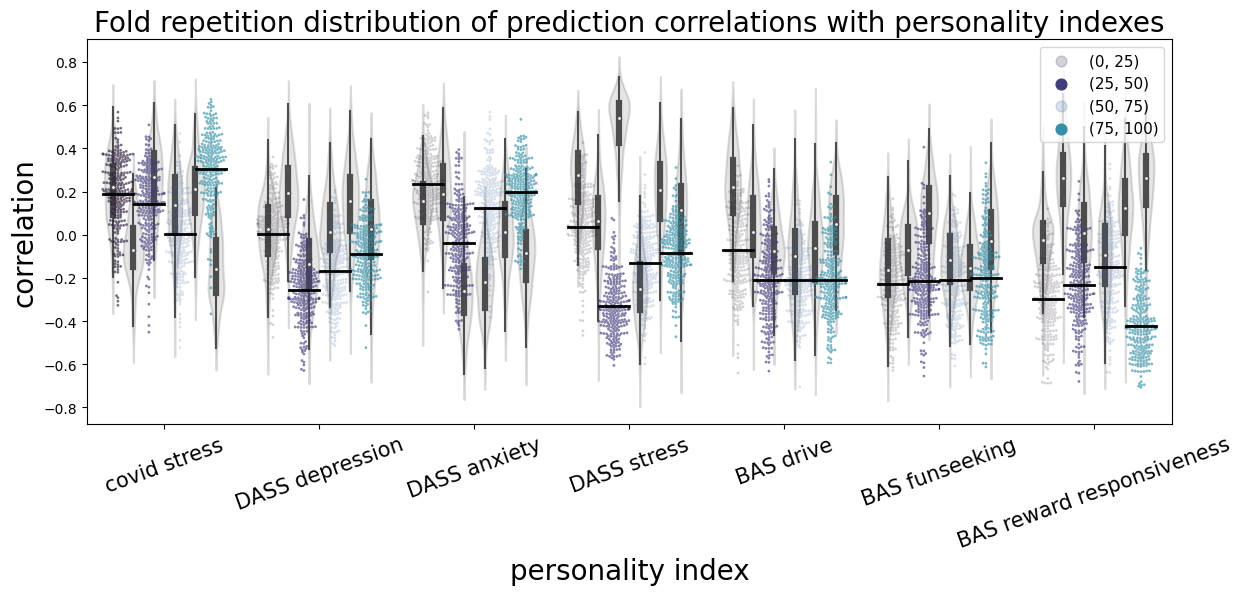

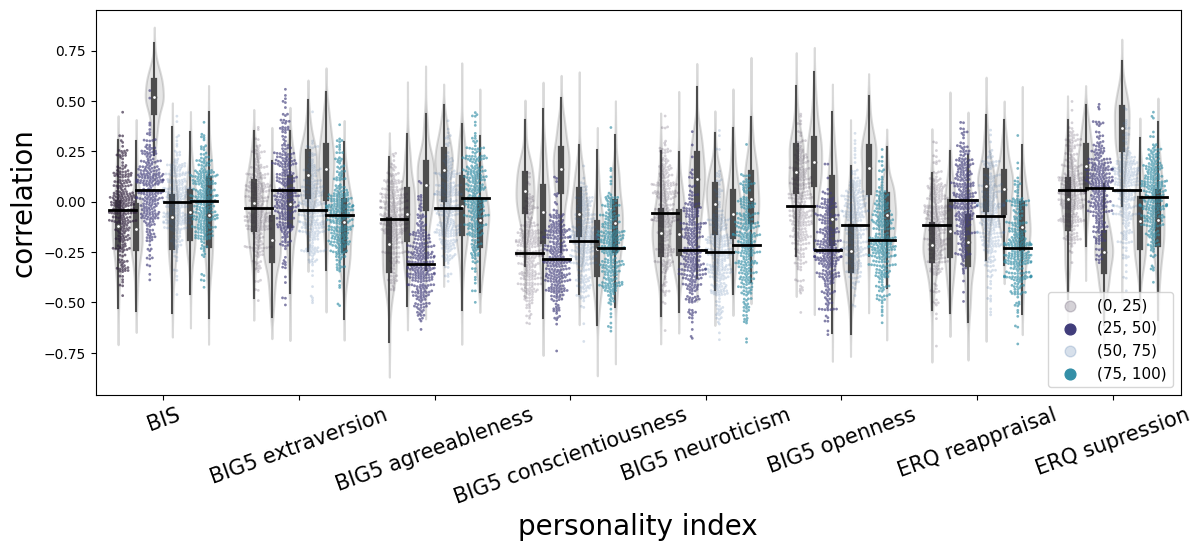

In [393]:
cur_df = pred_df[pred_df['type'].isin(B)]
plt.figure(figsize=(14,5))
p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(psy1)], hue="type", 
                  alpha=.65, size=2, dodge=True, 
                  palette=list(sns.color_palette("mako", as_cmap=False)[:len(B)]+['r','g'])
                 )
# plot the mean line
sns.boxplot(showmeans=True,meanline=True,meanprops={'color': 'k', 'ls': '-', 'lw': 2},medianprops={'visible': False},
            whiskerprops={'visible': False},zorder=10,x="pidx",y="corr", hue="type",
            data=cur_df[cur_df['pidx'].isin(psy1)],showfliers=False,showbox=False,showcaps=False,ax=p)

ax = sns.violinplot(showmeans=True,meanline=True,meanprops={'color': 'grey', 'ls': '-', 'lw': 2}
                    ,zorder=10,x="pidx",y="corr", hue="type",
            data=null_df[null_df['pidx'].isin(psy1)],ax=p, palette=sns.color_palette(['grey', 'grey']),
                   alpha=1)
for violin in np.array(ax.collections)[[i+2 for i in range(0,len(ax.collections)-2,2)]]:
    violin.set_alpha(0.2)

p.set_ylabel('correlation', fontsize=20)
p.set_xlabel('personality index', fontsize=20)
p.set_xticklabels(verbose1, fontsize=15,rotation=20)

handles, labels = p.get_legend_handles_labels()
p.legend(handles[:len(B)], labels[:len(B)], prop={'size': 11})

plt.title("Fold repetition distribution of prediction correlations with personality indexes", fontsize=20)
plt.show()

plt.figure(figsize=(14,5))
p = sns.swarmplot(x="pidx", y="corr", data=cur_df[cur_df['pidx'].isin(psy2)], hue="type",
                  alpha=.65, size=2, dodge=True,
                 palette=list(sns.color_palette("mako", as_cmap=False)[:len(B)]+['r','g']))

# plot the mean line
sns.boxplot(showmeans=True, meanline=True, meanprops={'color': 'k', 'ls': '-', 'lw': 2}, medianprops={'visible': False},
            whiskerprops={'visible': False},zorder=10,x="pidx",y="corr", hue="type",
            data=cur_df[cur_df['pidx'].isin(psy2)],showfliers=False,showbox=False,showcaps=False,ax=p)

ax = sns.violinplot(showmeans=True,meanline=True,meanprops={'color': 'grey', 'ls': '-', 'lw': 2}
                    ,zorder=10,x="pidx",y="corr", hue="type",
            data=null_df[null_df['pidx'].isin(psy2)],ax=p, palette=sns.color_palette(['grey', 'grey']),
                   alpha=1)
for violin in np.array(ax.collections)[[i+2 for i in range(0,len(ax.collections)-2,2)]]:
    violin.set_alpha(0.2)

p.set_ylabel('correlation', fontsize=20)
p.set_xlabel('personality index', fontsize=20)
p.set_xticklabels(verbose2, fontsize=15,rotation=20)

handles, labels = p.get_legend_handles_labels()
p.legend(handles[:len(B)], labels[:len(B)], prop={'size': 11}, loc=4)

plt.show()